Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.142403 s


'compile' took 1.526685 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.08e-01, 7.55e-01, 0.00e+00, 1.00e+00]    [2.10e-01, 7.75e-01, 0.00e+00, 1.00e+00]    [1.43e+00]    
1000      [9.27e-03, 8.90e-03, 4.54e-08, 4.27e-04]    [1.06e-02, 8.78e-03, 4.54e-08, 4.27e-04]    [8.23e-01]    
2000      [6.49e-03, 5.05e-03, 2.07e-07, 1.79e-04]    [7.00e-03, 5.15e-03, 2.07e-07, 1.79e-04]    [6.80e-01]    
3000      [3.90e-03, 4.04e-03, 1.33e-06, 8.32e-05]    [4.08e-03, 4.23e-03, 1.33e-06, 8.32e-05]    [5.31e-01]    
4000      [1.37e-03, 1.79e-03, 1.15e-06, 2.40e-05]    [1.46e-03, 1.61e-03, 1.15e-06, 2.40e-05]    [3.03e-01]    
5000      [2.31e-04, 3.81e-04, 1.15e-06, 2.40e-06]    [2.44e-04, 2.63e-04, 1.15e-06, 2.40e-06]    [1.02e-

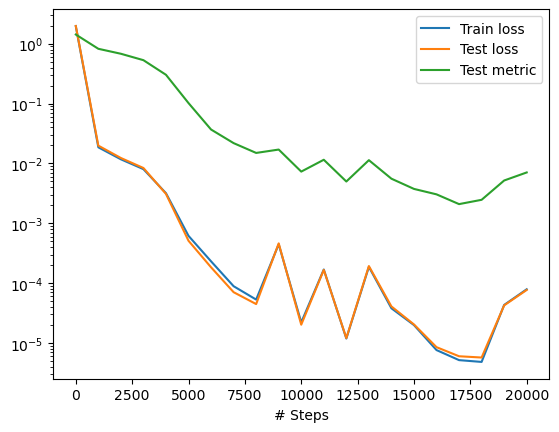

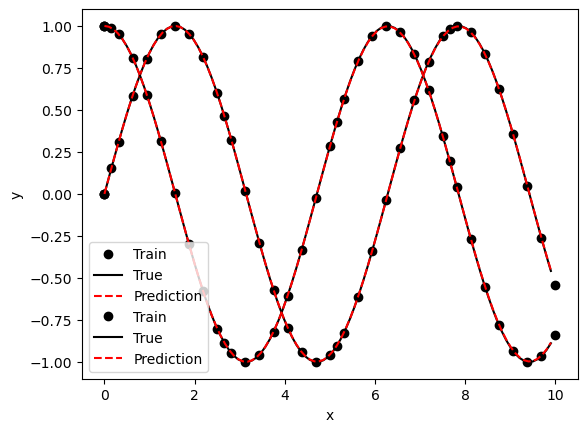

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
# Backend Selection 
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
# Import libraries
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np
import os

# Define PDES
def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # Most backends
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    # dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    # dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]

# Define Boundary (not condition)
def boundary(_, on_initial):
    return on_initial

# Define solution
def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

# Geometry domain 
geom = dde.geometry.TimeDomain(0, 10)
# Initial condition (Differnt way of definition than previous examples )
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
# Data compile (35 is points in domain, 2 is points at boundary)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

# Network Structure 
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Model compile
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
# Model Training 
losshistory, train_state = model.train(iterations=20000)
#Save and plot the result 
dde.saveplot(losshistory, train_state, issave=True, isplot=True)